# Field Data Acquisition and Analysis Group 2 Code

This file deals with the raw data used throughout the project. If you have access to this data, please ensure you have a data directory in the same folder as this notebook, and place the unique Garmin-formatted data in a subdirectory of data as sgar.

In [1]:
# Install requirements via pip if not already available
# Make sure you check your permissions.
# If you have these already, it's not necessary to run this cell.

!pip install pandas==2.0.1 matplotlib==3.6.2 scikit-learn==1.2.2

  Using cached pandas-2.0.1-cp38-cp38-win_amd64.whl (10.8 MB)
  Using cached scikit_learn-1.2.2-cp38-cp38-win_amd64.whl (8.3 MB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
  Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
  Using cached numpy-1.22.4-cp38-cp38-win_amd64.whl (14.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.1
    Uninstalling numpy-1.24.1:


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\programdata\\anaconda3\\lib\\site-packages\\numpy-1.24.1.dist-info\\entry_points.txt'
Consider using the `--user` option or check the permissions.



In [2]:
# Import statements
import ast
import datetime
import json
import pandas as pd
from pathlib import Path
from typing import Optional
import os
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


### Load data

In [3]:
########## LOAD DATA ##########
def depack_df(path: Path, key: Optional[str] = None, tag: Optional[str] = None):
    """
    Collects information from what is intended to be a csv file and expands out most values into new columns for use elsewhere.
    :param path: Path to a csv file.
    :param key: Optional key column to filter data if Key column is present.
    :param tag: Optional tag column to filter data if Tag column is present.
    :return: Dataframe of expanded data.
    """

    # load df
    df_temp = pd.read_csv(path)

    # Filter if necessary
    # variable settings are not optimal here but we should be fine given the scope
    if key and tag:
        df_set = df_temp[(df_temp["Tag"] == tag) & (df_temp["Key"] == key)]
    elif key and not tag:
        df_set = df_temp[(df_temp["Key"]) == key]
    elif tag and not key:
        df_set = df_temp[(df_temp["Tag"]) == tag]
    else:
        df_set = df_temp

    # because some files are uniquely strange, capitalize True/False to ensure reading succeeds
    df_set.loc[:, 'Value'] = df_set['Value'].apply(
        lambda x: x.replace(':false', ':False').replace(':true', ':True') if isinstance(x, str) else x)

    # set value column to dictionary
    df_set.loc[:, "Value"] = df_set["Value"].apply(ast.literal_eval)

    # Convert dictionaries to new df
    df_outer = pd.json_normalize(df_set["Value"])

    # re-set index to make merging possible
    df_outer.index = df_set.index

    # merge back together. Keep value json column because why not...
    df_outer = df_set.join(df_outer)

    # standardize datetime if possible
    for cols in df_outer.columns:
        if "time" in cols.lower():
            try:
                df_outer.loc[:, cols] = df_outer[cols].apply(pd.to_datetime, unit="s").dt.strftime("%Y-%m-%d %H:%M:%S")
            except:
                print("NOTE: Datetime not applied to:", cols)

    return (df_outer)


## Create empty dataframes to concat to
df_heartrate = pd.DataFrame()
df_sleep = pd.DataFrame()
df_sport_info = pd.DataFrame()
df_hr_fine = pd.DataFrame()
df_sleep_fine = pd.DataFrame()

# Get filenames in data directory
for filename in os.listdir(os.getcwd() + "\data"):

    if "hlth_center_aggregated_fitness_data.csv" in filename:
        hlthc_agg = Path("data\\" + filename)

        df_heartrate = pd.concat([df_heartrate, depack_df(hlthc_agg, key="heart_rate", tag="daily_report")],
                                 ignore_index=True)
        df_sleep = pd.concat([df_sleep, depack_df(hlthc_agg, key="sleep", tag="daily_report")], ignore_index=True)

    elif "hlth_center_sport_record.csv" in filename:
        hlthc_sport = Path("data\\" + filename)
        df_sport_info = pd.concat([df_sport_info, depack_df(hlthc_sport)], ignore_index=True)

    elif "hlth_center_fitness_data.csv" in filename:
        hlthc_fit = Path("data\\" + filename)
        df_hr_fine = pd.concat([df_hr_fine, depack_df(hlthc_fit, key="heart_rate")], ignore_index=True)
        df_sleep_fine = pd.concat([df_sleep_fine, depack_df(hlthc_fit, key="sleep")], ignore_index=True)

    elif "weather" in filename:
        df_weather = pd.read_csv(Path("data\\" + filename))

for filename in os.listdir(os.getcwd() + "\data\sgar"):

    if "heart_rate" in filename:
        with open(Path("data\\sgar\\" + filename)) as f:
            data = json.load(f)

            # When including heart rate of multiple days, top keys become dates. So I fixed that...
            all_heart_rate_values = []
            for date_key in data:
                heart_rate_values = data[date_key].get("heartRateValues", [])
                all_heart_rate_values.extend(heart_rate_values)
                uid_sgar = data[date_key].get("userProfilePK", [])

            # Convert to DataFrame
            df_hr_fine_sgar = pd.DataFrame(heart_rate_values, columns=["timestamp", "heartRate"])

            # Convert timestamp from milliseconds to seconds
            df_hr_fine_sgar["timestamp"] = df_hr_fine_sgar["timestamp"] // 1000  # Integer division

            # Convert timestamp to datetime
            df_hr_fine_sgar["timestamp"] = pd.to_datetime(df_hr_fine_sgar["timestamp"], unit="s")

            # TODO: determine if necessary to add heart rate zones here, or do later

    elif "sleep" in filename:

        # Load the JSON file
        with open(Path("data\\sgar\\" + filename)) as f:
            data = json.load(f)

            # Initialize an empty DataFrame for storing sleep data
            df_sleep_sgar = pd.DataFrame()

            # Iterate through each date_key in the data
            for date_key in data:
                # Extract the sleep data dictionary
                sleep_vals = data[date_key].get("dailySleepDTO", None)
                df_sleep_sgar = pd.concat([df_sleep_sgar, pd.DataFrame([sleep_vals])], ignore_index=True)

            # Convert timestamp to datetime for likely relevant columns
            df_sleep_sgar["sleepStartTimestampLocal"] = pd.to_datetime(df_sleep_sgar["sleepStartTimestampLocal"],
                                                                       unit="ms")
            df_sleep_sgar["sleepEndTimestampLocal"] = pd.to_datetime(df_sleep_sgar["sleepEndTimestampLocal"], unit="ms")


    elif "Activities" in filename:
        df_sport_info_sgar = pd.read_csv(Path("data\\sgar\\" + filename))



C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


### Merging Datasets

In [4]:
#### Merge datasets

# Merge heartrate fine
df_hr_fine = df_hr_fine.drop(columns=["Sid", "Key", "Time", "Value", "UpdateTime"])
df_hr_fine_sgar = df_hr_fine_sgar.rename(columns={"timestamp": "time", "heartRate": "bpm"})
df_hr_fine_sgar["Uid"] = uid_sgar
df_hr_fine = pd.concat([df_hr_fine, df_hr_fine_sgar], ignore_index=True)


# Merge sleep
# Start dropping columns...
df_sleep = df_sleep.drop(columns=["Sid",
                                  "Tag",
                                  "Key",
                                  "Value",
                                  "total_turn_over",
                                  "total_snore",
                                  "total_snore_disturb",
                                  "breath_quality",
                                  "day_sleep_evaluation",
                                  "segment_details",
                                  "total_body_move",
                                  "sleep_manually_duration",
                                  "total_long_duration",
                                  "UpdateTime",
                                  "sleep_stage",
                                  "sleep_trace_duration",
                                  "awake_count",
                                  "long_sleep_evaluation",
                                  "avg_hr",
                                  "avg_spo2",
                                  "max_hr",
                                  "min_spo2",
                                  "max_spo2",
                                  "min_hr",
                                  ])

df_sleep = df_sleep.rename(columns={"Time": "time"})



df_sleep_sgar = df_sleep_sgar.drop(columns=["sleepStartTimestampGMT",
                                            "sleepEndTimestampGMT",
                                            "autoSleepStartTimestampGMT",
                                            "autoSleepEndTimestampGMT",
                                            "unmeasurableSleepSeconds",
                                            "deviceRemCapable",
                                            "retro",
                                            "lowestRespirationValue",
                                            "highestRespirationValue",
                                            "averageRespirationValue",
                                            "id",
                                            "sleepWindowConfirmed",
                                            "sleepWindowConfirmationType",
                                            "sleepQualityTypePK",
                                            "sleepResultTypePK",
                                            "sleepEndTimestampLocal",
                                            "sleepStartTimestampLocal"
                                            ])


# Convert time from seconds to minutes manually
colnames = ["deepSleepSeconds", "lightSleepSeconds", "remSleepSeconds", "awakeSleepSeconds", "sleepTimeSeconds", "napTimeSeconds"]

for cols in colnames:
    df_sleep_sgar[cols] = df_sleep_sgar[cols] / 60

df_sleep_sgar = df_sleep_sgar.rename(columns={"userProfilePK": "Uid",
                                              "deepSleepSeconds": "sleep_deep_duration",
                                              "lightSleepSeconds": "sleep_light_duration",
                                              "remSleepSeconds": "sleep_rem_duration",
                                              "awakeSleepSeconds": "sleep_awake_duration",
                                              "calendarDate": "time",
                                              "sleepTimeSeconds": "total_duration",
                                              "napTimeSeconds": "sleep_nap_duration",
                                              })
# Convert calendar date to datetime
df_sleep_sgar.loc[:, "time"] = df_sleep_sgar["time"].apply(pd.to_datetime)


# Merge the dataframes
df_sleep = pd.concat([df_sleep, df_sleep_sgar], ignore_index=True)
# Nans are used instead of 0s for nap, replace for ease of use later
df_sleep["sleep_nap_duration"] = df_sleep["sleep_nap_duration"].fillna(0)
df_sleep["sleep_score"] = df_sleep["sleep_score"].fillna(0)


# Merge activities and remove an activity that was not measured on a watch
# Remove not-watch measured activity (probs not gonna be included anyways due to date but i've yet to filter that)
df_sport_info = df_sport_info[df_sport_info['Sid'].apply(lambda x: isinstance(x, int))]

df_sport_info = df_sport_info.drop(columns=["Sid",
                                            "Key",
                                            "Value",
                                            "Time", # note that this one gets repeated hence why it is GONE
                                            "UpdateTime",
                                            "vitality",
                                            "cloud_course_source",
                                            "did",
                                            "designated_course",
                                            "switch_just_dance_id",
                                            "avg_touchdown_air_ratio",
                                            "half_marathon_grade_prediction_duration",
                                            "fall_height",
                                            "five_kilometre_grade_prediction_duration",
                                            "min_touchdown_air_ratio",
                                            "full_marathon_grade_prediction_duration",
                                            "ten_kilometre_grade_prediction_duration",
                                            "max_cadence",
                                            "max_height",
                                            "max_pace",
                                            "max_speed",
                                            "min_height",
                                            "min_pace",
                                            "proto_type",
                                            "sport_type",
                                            "entityEndTime",
                                            "entityOffsetTime",
                                            "entityStartTime",
                                            "avg_speed",
                                            "running_ability_index",
                                            "rise_height",
                                            "training_status",
                                            "avg_stride",
                                            "avg_height",
                                            "end_time",
                                            "start_time",
                                            "timezone",
                                            "version",
                                            "total_cal",
                                            "avg_cadence",
                                            "avg_pace",
                                            "running_ability_level",
                                            "training_experience",
                                            "valid_duration",
                                            "distance",
                                            "vo2_max_level",
                                            "steps",
                                            "anaerobic_train_effect_level",
                                            "aerobic_train_effect_level",
                                            "train_load_level"
                                            ])

df_sport_info_sgar = df_sport_info_sgar.drop(columns=["Favorite",
                                                      "Best Lap Time",
                                                      "Number of Laps",
                                                      "Title",
                                                      "Distance",
                                                      "Max Cadence",
                                                      "Avg Pace",
                                                      "Best Pace",
                                                      "Total Ascent",
                                                      "Total Descent",
                                                      "Avg Stride Length",
                                                      "Steps",
                                                      "Decompression",
                                                      "Moving Time",
                                                      "Elapsed Time",
                                                      "Min Elevation",
                                                      "Max Elevation",
                                                      "Avg Cadence"
                                                      ])

df_sport_info_sgar = df_sport_info_sgar.rename(columns={"Activity Type": "Category",
                                                        "Date": "time",
                                                        "Time": "duration",
                                                        "Training Stress Score®": "train_load",
                                                        "Calories": "calories",
                                                        "Max HR": "max_hrm",
                                                        "Avg HR": "avg_hrm",
                                                        })
# Add UID
df_sport_info_sgar["Uid"] = uid_sgar


# Note that there will be some NaNs due to sgar data not having the columns but I felt the cols were important to keep
df_sport_info = pd.concat([df_sport_info, df_sport_info_sgar], ignore_index=True)


# Column renaming for consistency
df_heartrate = df_heartrate.rename(columns={"Time": "time"})
df_sleep_fine = df_sleep_fine.rename(columns={"Time": "time"})
df_weather = df_weather.rename(columns={"date": "time"})

# Column dropping for other dataframes
df_heartrate = df_heartrate.drop(columns=["Sid",
                                          "Tag",
                                          "Key",
                                          "Value",
                                          "UpdateTime",
                                          "latest_hr.bpm",
                                          "latest_hr.time",
                                          "latest_hr.dbKey",
                                          "latest_hr.dbTime",
                                          "latest_hr.sid",
                                          ])

df_sleep_fine = df_sleep_fine.drop(columns=["Sid",
                                            "Key",
                                            "Value",
                                            "UpdateTime",
                                            "device_bedtime",
                                            "device_wake_up_time",
                                            "timezone",
                                            "version",
                                            "protoTime",
                                            "has_rem",
                                            "has_stage",
                                            ])


########## PROCESS ##########

#### RELEVANT DFs:
# df_heartrate: contains aggregated hr data from daily report. Not merged with SGAR data!!!!
# df_sleep: contains aggregated sleep data from daily report
# df_sport_info: contains information about exercise records
# df_hr_fine: contains raw measurements of hr throughout the day. These are the by-minute measurements!
# df_sleep_fine: contains raw measurements of sleep. Not merged with SGAR data!!!! Don't recommend for calculations, but items column contains information that makes the sleep graph.
# df_weather: contains weather data.


# Collect overlap times in data
# This might not actually be calculated correctly given the other dataframes but it is due to Sgar's data
# Which somehow only measures a day??????
unique_ids = df_heartrate["Uid"].unique()
df_heartrate['time'] = pd.to_datetime(df_heartrate['time'], errors='coerce')
min_times = []
max_times = []

for uid in unique_ids:
    user_data = df_heartrate[df_heartrate["Uid"] == uid]
    if not user_data.empty:
        min_times.append(user_data["time"].min())
        max_times.append(user_data["time"].max())

# Now get the overlap window
min_time = pd.to_datetime(max(min_times)).ceil("D")   # Latest start (rounded *up*)
max_time = pd.to_datetime(min(max_times)).floor("D")  # Earliest end (rounded *down*)

# Test print
print("Overlap time window:", min_time, "to", max_time)


# Check time
df_heartrate['time'] = pd.to_datetime(df_heartrate['time'])
df_sleep["time"] = pd.to_datetime(df_sleep["time"])
df_sport_info["time"] = pd.to_datetime(df_sport_info["time"])
df_hr_fine["time"] = pd.to_datetime(df_hr_fine["time"])
df_sleep_fine["time"] = pd.to_datetime(df_sleep_fine["time"])
df_weather["time"] = pd.to_datetime(df_weather["time"])

#Filter every dataframe to include information from only the min and max time dates
df_heartrate = df_heartrate[(df_heartrate["time"] >= min_time) & (df_heartrate["time"] <= max_time)]
df_sleep = df_sleep[(df_sleep["time"] >= min_time) & (df_sleep["time"] <= max_time)]
df_sport_info = df_sport_info[(df_sport_info["time"] >= min_time) & (df_sport_info["time"] <= max_time)]
df_hr_fine = df_hr_fine[(df_hr_fine["time"] >= min_time) & (df_hr_fine["time"] <= max_time)]
df_sleep_fine = df_sleep_fine[(df_sleep_fine["time"] >= min_time) & (df_sleep_fine["time"] <= max_time)]
df_weather = df_weather[(df_weather["time"] >= min_time) & (df_weather["time"] <= max_time)]

# create dictionary of weather locations for any future use
id_wx_match = {8279638506 : "Eindhoven",
               8279777108: "Eindhoven",
               123645046: "Eindhoven",
               8280113902: "Tilburg",
               8279810348: "Eersel"}

Overlap time window: 2025-02-26 00:00:00 to 2025-03-27 00:00:00


## Linear Models and Visualizations

### Preliminary Visualizations: Heart Rate Average Daily Per User

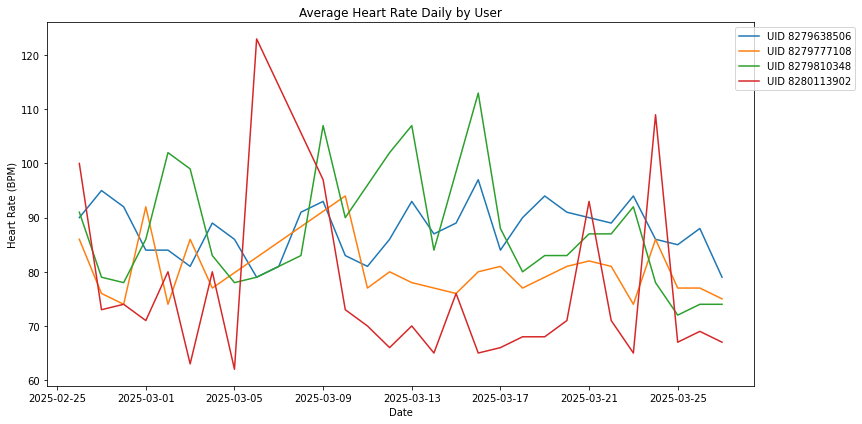

In [5]:
# Sort datetime values for sake of use
df_heartrate.loc[:, 'time'] = pd.to_datetime(df_heartrate['time'])
df_heartrate = df_heartrate.sort_values(by='time')

# Plot one line per UID
plt.figure(figsize=(12, 6))
for uid, group in df_heartrate.groupby("Uid"):
    plt.plot(group["time"], group["avg_hr"], label=f"UID {uid}")

plt.xlabel("Date")
plt.ylabel("Heart Rate (BPM)")
plt.title("Average Heart Rate Daily by User")
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

### Preliminary Visualizations: Heart Rate Per Minute Per User

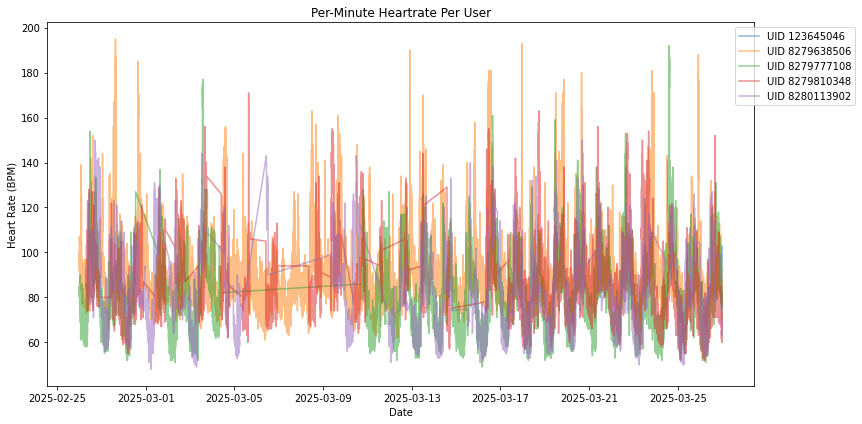

In [6]:
# Sort datetime values for sake of use
df_hr_fine.loc[:, 'time'] = pd.to_datetime(df_hr_fine['time'])
df_hr_fine = df_hr_fine.sort_values(by='time')

# Plot one line per UID
plt.figure(figsize=(12, 6))
for uid, group in df_hr_fine.groupby("Uid"):
    plt.plot(group["time"], group["bpm"], label=f"UID {uid}", alpha=0.5)

plt.xlabel("Date")
plt.ylabel("Heart Rate (BPM)")
plt.title("Per-Minute Heartrate Per User")
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

### Preliminary Visualizations: Daily Sleep Duration Per User

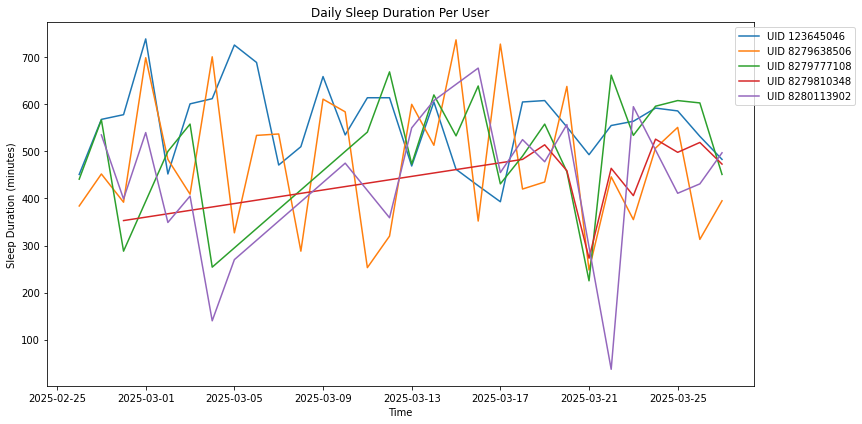

In [7]:
# Sort datetime values for sake of use
df_sleep.loc[:, 'time'] = pd.to_datetime(df_sleep['time'])
df_sleep = df_sleep.sort_values(by='time')

# Plot one line per UID
plt.figure(figsize=(12, 6))
for uid, group in df_sleep.groupby("Uid"):
    plt.plot(group["time"], group["total_duration"], label=f"UID {uid}")

plt.xlabel("Time")
plt.ylabel("Sleep Duration (minutes)")
plt.title("Daily Sleep Duration Per User")
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

### Predicting sleep score based on heart rate zones during an activity and time difference between activity and start of sleep.

time_x    0
time_y    0
dtype: int64
          Uid           Category  avg_hrm  calories  duration_x  \
0  8279777108  strength_training      131       686        4028   
1  8279777108          badminton      143       239        1289   
2  8279777108  strength_training      122       518        3231   
3  8279777108  strength_training      131       789        4786   
4  8279777108          badminton      175       846        4077   

   hrm_aerobic_duration  hrm_anaerobic_duration  hrm_extreme_duration  \
0                1210.0                   228.0                   0.0   
1                 926.0                   169.0                   0.0   
2                 240.0                     0.0                   0.0   
3                1732.0                    55.0                   0.0   
4                  15.0                  1090.0                2951.0   

   hrm_fat_burning_duration  hrm_warm_up_duration  ...  min_spo2  \
0                    2359.0                 217.0  ..

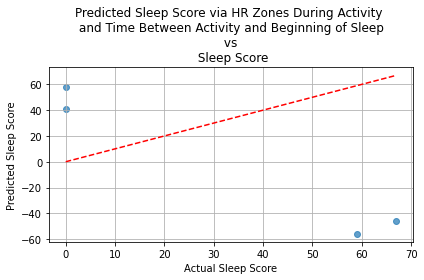

Intercept: 20.579459336654892
Coefficients:
  time_diff: 0.011794375907805856
  hrm_aerobic_duration: 0.0224043439485005
  hrm_anaerobic_duration: -0.5759040173811769
  hrm_extreme_duration: 0.2323680955927265
  hrm_fat_burning_duration: 0.007273978945536949
  hrm_warm_up_duration: 0.01179829483662044


In [8]:
######### LINEAR MODELS AND OTHER
#### RELEVANT DFs:
# df_heartrate: contains aggregated hr data from daily report. Not merged with SGAR data!!!!
# df_sleep: contains aggregated sleep data from daily report
# df_sport_info: contains information about exercise records
# df_hr_fine: contains raw measurements of hr throughout the day. These are the by-minute measurements!
# df_sleep_fine: contains raw measurements of sleep. Not merged with SGAR data!!!! Don't recommend for calculations, but items column contains information that makes the sleep graph.
# df_weather: contains weather data.

# # Create linear regression model
l_mdl = LinearRegression()

# Function to convert time string to seconds
def convert_to_seconds(value):
    if isinstance(value, str):  # If the value is a string
        # Remove anything after the decimal point (i.e., milliseconds)
        value = value.split('.')[0]
        time_obj = datetime.datetime.strptime(value, "%H:%M:%S")
        total_seconds = time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second
        return total_seconds
    else:
        return value  # If it's an integer, return as is (assuming it's in seconds)

# # Apply the conversion function to the 'duration' column in df_sport_info
df_sport_info["duration"] = df_sport_info["duration"].apply(convert_to_seconds)
df_sport_info = df_sport_info.fillna(0)
#
# # Convert time columns to datetime if they aren't already
df_sport_info["day"] = pd.to_datetime(df_sport_info["time"]).dt.date
df_sleep_fine["day"] = pd.to_datetime(df_sleep_fine["time"]).dt.date
df_sleep["day"] = pd.to_datetime(df_sleep["time"]).dt.date
#
# # Shift sleep dates back by 1 day for merging
df_sleep_fine["activity_day"] = df_sleep_fine["day"] - pd.Timedelta(days=1)
#
# Merge where activity happened the day *before* sleep
df_merged = pd.merge(
    df_sport_info,
    df_sleep_fine,
    left_on=["day", "Uid"],
    right_on=["activity_day", "Uid"],
    how="inner"
)
#
# Ensure both time columns are in datetime format for timedelta calculation
df_merged["time_x"] = pd.to_datetime(df_merged["time_x"], errors='coerce')  # Coerce invalid values to NaT
df_merged["time_y"] = pd.to_datetime(df_merged["time_y"], errors='coerce')  # Coerce invalid values to NaT

# Check if there are any invalid datetime entries
print(df_merged[["time_x", "time_y"]].isna().sum())

# Ensure 'bedtime' is in datetime format
df_merged["bedtime"] = pd.to_datetime(df_merged["bedtime"], errors='coerce')

# Calculate time difference between activity end and sleep
df_merged["time_diff"] = (df_merged["bedtime"] - df_merged["time_x"]).dt.total_seconds() / 60

# Print the result to check
print(df_merged.head())
#
# Now prepare the features (X) and target (y) for linear regression
x = df_merged[["time_diff",
               "hrm_aerobic_duration",
               "hrm_anaerobic_duration",
               "hrm_extreme_duration",
               "hrm_fat_burning_duration",
               "hrm_warm_up_duration"]]

y = df_sleep["sleep_score"]

# First, get the shorter length of x and y
min_len = min(len(x), len(y))
print(min_len)

# Sample both X and y to match the minimum length
x_sampled = x.sample(n=min_len, random_state=42)
y_sampled = y.sample(n=min_len, random_state=42)

# Align them by index after sampling
x_sampled = x_sampled.sort_index()
y_sampled = y_sampled.sort_index()

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x_sampled, y_sampled, test_size=0.2, random_state=42)

# Fit the model and predict
l_mdl.fit(x_train, y_train)
y_pred = l_mdl.predict(x_test)

# Print R^2 score (how well the model fits)
print("Model R^2 score on test set:", l_mdl.score(x_test, y_test))

# Optional: Plotting Predicted vs Actual
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual Sleep Score")
plt.ylabel("Predicted Sleep Score")
plt.title("Predicted Sleep Score via HR Zones During Activity \n and Time Between Activity and Beginning of Sleep \n vs \n Sleep Score")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print intercept and coefficients
print("Intercept:", l_mdl.intercept_)
print("Coefficients:")
for feature, coef in zip(x.columns, l_mdl.coef_):
    print(f"  {feature}: {coef}")

### Predicting Deep Sleep Duration Based on Increased Intensity Heartrate Zones Throughout the Day

111
Model R^2 score on test set: -0.0356513367835245


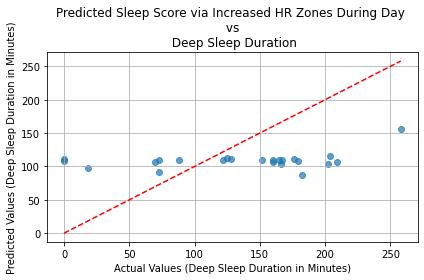

Intercept: 110.63800977771697
Coefficients:
  aerobic_hr_zone_duration: 0.8348035407395052
  anaerobic_hr_zone_duration: -0.7271851193234099
  extreme_hr_zone_duration: 3.375286900923806
  fat_burning_hr_zone_duration: -0.3682792233787149


In [9]:
###### LM 2 #########
# Spending more time in higher heart rate zones during the day leads to an increased percentage of deep sleep
# during the night.

l_mdl2 = LinearRegression()


x = df_heartrate[["aerobic_hr_zone_duration",
                 "anaerobic_hr_zone_duration",
                 "extreme_hr_zone_duration",
                 "fat_burning_hr_zone_duration",]]

y = df_sleep["sleep_deep_duration"]

min_len = min(len(x), len(y))
print(min_len)


# Then randomly sample both to that length, using the same random_state for reproducibility
x_sampled = x.sample(n=min_len, random_state=42)
y_sampled = y.sample(n=min_len, random_state=42)

# Important: align them by index after sampling
x_sampled = x_sampled.sort_index()
y_sampled = y_sampled.sort_index()



x_train, x_test, y_train, y_test = train_test_split(x_sampled, y_sampled, test_size=0.2, random_state=42)


# Fit and show
l_mdl2.fit(x_train, y_train)
y_pred = l_mdl2.predict(x_test)

# Print R^2 score (how well the model fits)
print("Model R^2 score on test set:", l_mdl2.score(x_test, y_test))

# Plot: predicted vs actual
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual Values (Deep Sleep Duration in Minutes)")
plt.ylabel("Predicted Values (Deep Sleep Duration in Minutes)")
plt.title("Predicted Sleep Score via Increased HR Zones During Day \n vs \n Deep Sleep Duration")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # ideal line
plt.grid(True)
plt.tight_layout()
plt.show()

# Print intercept and coefficients
print("Intercept:", l_mdl2.intercept_)
print("Coefficients:")

for feature, coef in zip(x.columns, l_mdl2.coef_):
    print(f"  {feature}: {coef}")

### Predicting Sleep Score Based On Calories, Duration, and Increased Heart Rate Zones

39
Model R^2 score on test set: -199.9873295194582


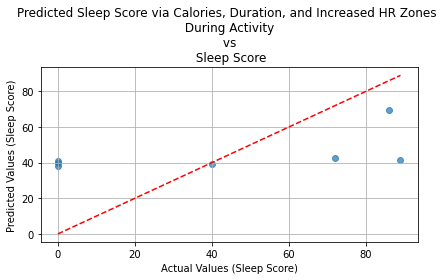

Intercept: 38.53278556221579
Coefficients:
  calories: -0.034971500484413456
  duration: 0.0037011670674951436
  hrm_aerobic_duration: -0.008440498767403402
  hrm_anaerobic_duration: 0.06676491659856217
  hrm_extreme_duration: 0.5067801805300043
  hrm_fat_burning_duration: 0.018443211167015354


In [10]:
# Higher daily energy expenditure (measured through calories burned) is associated with better overall sleep
# quality

l_mdl3 = LinearRegression()


x = df_sport_info[["calories",
                   "duration",
                   "hrm_aerobic_duration",
                   "hrm_anaerobic_duration",
                   "hrm_extreme_duration",
                   "hrm_fat_burning_duration",]]


y = df_sleep["sleep_score"]

min_len = min(len(x), len(y))
print(min_len)


# Then randomly sample both to that length, using the same random_state for reproducibility
x_sampled = x.sample(n=min_len, random_state=42)
y_sampled = y.sample(n=min_len, random_state=42)

# Important: align them by index after sampling
x_sampled = x_sampled.sort_index()
y_sampled = y_sampled.sort_index()



x_train, x_test, y_train, y_test = train_test_split(x_sampled, y_sampled, test_size=0.2, random_state=42)


# Fit and show
l_mdl3.fit(x_train, y_train)
y_pred = l_mdl3.predict(x_test)

# Print R^2 score (how well the model fits)
print("Model R^2 score on test set:", l_mdl3.score(x_test, y_test))

# Apply the condition to filter both y_pred and y_test
mask = (y_pred <= 100) & (y_pred >= -50) & (y_test <= 100) & (y_test >= -50)

# Apply the mask to both y_pred and y_test to filter them
y_pred_filtered = y_pred[mask]
y_test_filtered = y_test[mask]

# Plot: predicted vs actual
plt.scatter(y_test_filtered, y_pred_filtered, alpha=0.7)
plt.xlabel("Actual Values (Sleep Score)")
plt.ylabel("Predicted Values (Sleep Score)")
plt.title("Predicted Sleep Score via Calories, Duration, and Increased HR Zones \n During Activity \n vs \n Sleep Score")
plt.plot([y_test_filtered.min(), y_test_filtered.max()], [y_test_filtered.min(), y_test_filtered.max()], color='red', linestyle='--')  # ideal line
plt.grid(True)
plt.tight_layout()
plt.show()

# Print intercept and coefficients
print("Intercept:", l_mdl3.intercept_)
print("Coefficients:")

for feature, coef in zip(x.columns, l_mdl3.coef_):
    print(f"  {feature}: {coef}")